<a href="https://colab.research.google.com/github/areias/bert_covid_sentiment/blob/main/bert_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


https://www.tensorflow.org/text/tutorials/fine_tune_bert

https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

http://mccormickml.com/2019/07/22/BERT-fine-tuning/

https://www.thepythoncode.com/article/finetuning-bert-using-huggingface-transformers-python

https://colab.research.google.com/github/digitalepidemiologylab/covid-twitter-bert/blob/master/CT_BERT_Huggingface_(GPU_training).ipynb



## http://mccormickml.com/2019/07/22/BERT-fine-tuning/ 22 Jul 2019, Revised on 3/20/20

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 7.9 MB/s 
     |████████████████████████████████| 895 kB 56.4 MB/s 
     |████████████████████████████████| 59 kB 7.3 MB/s 
     |████████████████████████████████| 596 kB 60.7 MB/s 
     |████████████████████████████████| 3.3 MB 40.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("drive/MyDrive/covid-twitter-bert/data/finetune/originals/crowdbreaks/train.tsv", delimiter='\t', header=0, names=['id', 'label', 'sentence'])


In [6]:
df['label'].value_counts()

 0    686
-1    678
 1    677
Name: label, dtype: int64

In [7]:
df.loc[df['label']==-1,'label']=2

In [8]:
df['label'].value_counts()

0    686
2    678
1    677
Name: label, dtype: int64

In [9]:
df.sample(10)

,id,label,sentence
879,435638533626540032,1,how many kids aren't getting vaccinated? http:...
991,394477949019505024,1,@ChilledChaos I have Autism and yet I hardly e...
1120,440543774817923008,1,Baby's doctor appointment he's got some vaccin...
997,510808840737419008,1,Attend Health&amp;Safety mtg discussion on HPV...
834,562694415115096000,0,FFS --&gt; RT @thinkprogress: Congressman: Me...
1997,108227844164944000,0,Listening to Pierre Robert on MMR while eating...
689,468869706292945024,1,"""@HuffingtonPost: 300 million children could b..."
1127,467011773736825024,1,"""@TeamMorgan2014: Woman's cancer wiped out by ..."
1016,247112733944860992,0,Mmr go gett em
831,509696511559864000,1,"The Case for Vaccinating Your Kids, in One Ala..."


## Pre-processing Tweets

In [10]:
import sys
sys.path.append('drive/MyDrive/covid-twitter-bert')
sys.path.append('drive/MyDrive/covid-twitter-bert/tensorflow_models')



In [11]:
!pip install emoji

     |████████████████████████████████| 170 kB 8.0 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=2526d39968094a824a6717f6e6b2dd82841a231a4d95bdc440dedf60ddfc7e80
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [12]:
!pip install unidecode

     |████████████████████████████████| 235 kB 9.9 MB/s 


In [13]:
!pip install spacy==3

     |████████████████████████████████| 12.7 MB 7.8 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 628 kB 50.0 MB/s 
     |████████████████████████████████| 451 kB 49.7 MB/s 
     |████████████████████████████████| 9.1 MB 51.0 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [14]:
from utils.preprocess import preprocess_bert

In [15]:
from collections import namedtuple
arguments = namedtuple('arguments', ['run_prefix','finetune_datasets','model_class',
                                     'max_seq_length', 'asciify_emojis','username_filler',
                                    'url_filler', 'replace_multiple_usernames','replace_multiple_urls',
                                      'remove_unicode_symbols','replace_usernames','replace_urls',
                                     'standardize_punctuation','remove_accented_characters'])

args = arguments("test_run",["crowdbreaks"],"covid-twitter-bert-2",
                 96, True, "twitteruser", 
                 "twitterurl", True,True,
                 True, True, True,
                 True, True)
args



arguments(run_prefix='test_run', finetune_datasets=['crowdbreaks'], model_class='covid-twitter-bert-2', max_seq_length=96, asciify_emojis=True, username_filler='twitteruser', url_filler='twitterurl', replace_multiple_usernames=True, replace_multiple_urls=True, remove_unicode_symbols=True, replace_usernames=True, replace_urls=True, standardize_punctuation=True, remove_accented_characters=True)

In [16]:
df['sentence'] = df['sentence'].apply(lambda x: preprocess_bert(x,args,do_lower_case=True))

In [17]:
#Let’s extract the sentences and labels of our training set as numpy ndarrays.

# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values


In [18]:
sentences[0]

'arizona classrooms vulnerable to measles outbreak: the arizona department of health services looked at herd... twitterurl'

In [19]:
type(labels[0])

numpy.int64

## BERT Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT–the below cell will download this for us. We’ll be using the “uncased” version here.

In [20]:
from transformers import AutoTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
model_name = 'digitalepidemiologylab/covid-twitter-bert-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/421 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  arizona classrooms vulnerable to measles outbreak: the arizona department of health services looked at herd... twitterurl
Tokenized:  ['arizona', 'classrooms', 'vulnerable', 'to', 'me', '##as', '##les', 'outbreak', ':', 'the', 'arizona', 'department', 'of', 'health', 'services', 'looked', 'at', 'herd', '.', '.', '.', 'twitter', '##ur', '##l']
Token IDs:  [5334, 12463, 8211, 2000, 2033, 3022, 4244, 8293, 1024, 1996, 5334, 2533, 1997, 2740, 2578, 2246, 2012, 14906, 1012, 1012, 1012, 10474, 3126, 2140]


The above code left out a few required formatting steps:
* Add special tokens to the start and end of each sentence.
* Pad & truncate all sentences to a single constant length.
* Explicitly differentiate real tokens from padding tokens with the “attention mask”.


In [22]:
tokenizer.encode_plus(sentences[0],                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 96,           # Pad & truncate all sentences.
                        padding= True,
                        return_attention_mask = True,   # Construct attn. masks.
                      truncation=True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

{'input_ids': tensor([[  101,  5334, 12463,  8211,  2000,  2033,  3022,  4244,  8293,  1024,
          1996,  5334,  2533,  1997,  2740,  2578,  2246,  2012, 14906,  1012,
          1012,  1012, 10474,  3126,  2140,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])}

In [23]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 96,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt', 
                        truncation=True    # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [24]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


In [25]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks, labels)


In [26]:
# do all above for validation dataset

# Load the dataset into a pandas dataframe.
df2 = pd.read_csv("drive/MyDrive/covid-twitter-bert/data/finetune/originals/crowdbreaks/dev.tsv", delimiter='\t', header=0, names=['id', 'label', 'sentence'])
df2.loc[df2['label']==-1,'label']=2

# pre-processes special characters
df2['sentence'] = df2['sentence'].apply(lambda x: preprocess_bert(x,args,do_lower_case=True))

In [27]:
df2.head()

,id,label,sentence
0,522873565969150016,1,"flu shot, got. #vaccinated #flushot #diseasepr..."
1,371691166674451968,1,idiots. twitteruser : texas measles outbreak t...
2,70612980194226200,1,at the vet my baby is getting a vaccination aw...
3,562391001118289984,2,today in journalism my professor said friend's...
4,239016379901177984,2,twitteruser and children getting vaccinated st...


In [28]:
# Get the lists of sentences and their labels.
test_sentences = df2.sentence.values
test_labels = df2.label.values

In [29]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 96,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
test_labels[0].item()

1

In [31]:
# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)


In [32]:
val_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)


In [33]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


## Fine-tuning

In [41]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(  
    'digitalepidemiologylab/covid-twitter-bert-v2', # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
     return_dict=False)

# Tell pytorch to run this model on the GPU.
model.cuda()


Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClass

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [42]:
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [76]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [77]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



In [78]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [79]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

In [80]:
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    256.    Elapsed: 0:00:13.
  Batch    80  of    256.    Elapsed: 0:00:25.
  Batch   120  of    256.    Elapsed: 0:00:38.
  Batch   160  of    256.    Elapsed: 0:00:50.
  Batch   200  of    256.    Elapsed: 0:01:03.
  Batch   240  of    256.    Elapsed: 0:01:15.

  Average training loss: 0.57
  Training epcoh took: 0:01:20

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.71
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    256.    Elapsed: 0:00:13.
  Batch    80  of    256.    Elapsed: 0:00:25.
  Batch   120  of    256.    Elapsed: 0:00:38.
  Batch   160  of    256.    Elapsed: 0:00:50.
  Batch   200  of    256.    Elapsed: 0:01:03.
  Batch   240  of    256.    Elapsed: 0:01:15.

  Average training loss: 0.46
  Training epcoh took: 0:01:20

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.72
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
 

In [81]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.57,0.71,0.78,0:01:20,0:00:07
2,0.46,0.72,0.78,0:01:20,0:00:07
3,0.32,0.85,0.78,0:01:20,0:00:07
4,0.23,0.86,0.79,0:01:20,0:00:07


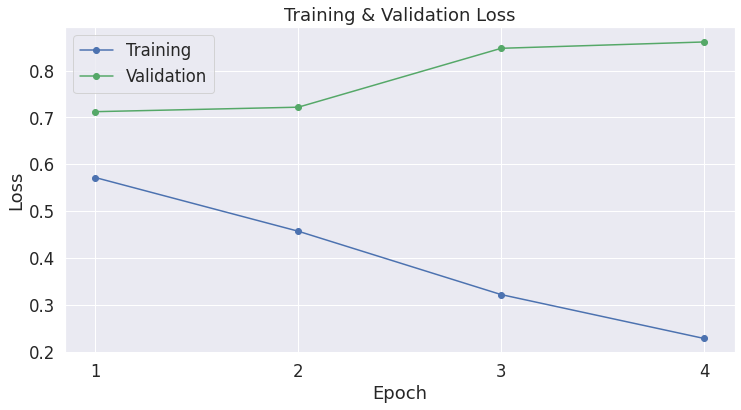

In [82]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [83]:
## Performance on test set
df3 = pd.read_csv("drive/MyDrive/covid-twitter-bert/data/finetune/originals/crowdbreaks/test.tsv", delimiter='\t', header=0, names=['id', 'label', 'sentence'])
df3.loc[df3['label']==-1,'label']=2
# pre-processes special characters
df3['sentence'] = df3['sentence'].apply(lambda x: preprocess_bert(x,args,do_lower_case=True))

In [84]:
df3['label'].value_counts()

2    237
1    225
0    219
Name: label, dtype: int64

In [86]:
test_sentences = df3.sentence.values
test_labels = df3.label.values

test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 96,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
batch_size=8

input_ids = torch.cat(test_input_ids, dim=0)
attention_masks = torch.cat(test_attention_masks, dim=0)
labels = torch.tensor(test_labels)

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Prediction on test set

In [87]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 681 test sentences...
    DONE.


In [88]:
from sklearn.metrics import f1_score

f1_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating F1 Score. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  f1 = f1_score(true_labels[i], pred_labels_i, average=None)                
  f1_set.append(f1)

Calculating F1 Score. Coef. for each batch...


In [89]:
len(f1_set)

86

In [90]:
f1_set

[array([0.85714286, 0.5       , 0.8       ]),
 array([0.        , 0.85714286, 0.66666667]),
 array([1.        , 0.66666667, 0.85714286]),
 array([0.66666667, 0.66666667, 0.5       ]),
 array([0.4, 0.5, 0. ]),
 array([0.57142857, 0.66666667]),
 array([0.5       , 0.66666667, 1.        ]),
 array([1., 1., 1.]),
 array([0. , 0.6, 0. ]),
 array([0.85714286, 0.88888889]),
 array([0.57142857, 0.5       , 0.4       ]),
 array([1.        , 0.90909091, 0.        ]),
 array([1.        , 0.8       , 0.88888889]),
 array([0.5 , 0.75, 0.5 ]),
 array([0.75, 0.4 , 0.  ]),
 array([0.66666667, 0.5       , 0.66666667]),
 array([1. , 0.8, 0.8]),
 array([0.        , 0.66666667, 0.83333333]),
 array([1.        , 0.8       , 0.66666667]),
 array([0.66666667, 0.33333333, 0.57142857]),
 array([0.5       , 0.85714286, 0.8       ]),
 array([0.        , 0.85714286, 0.85714286]),
 array([0.85714286, 0.8       , 1.        ]),
 array([0.8       , 0.85714286, 1.        ]),
 array([0.90909091, 0.        , 0.66666667]

In [91]:
true_labels[0]

array([0, 0, 0, 1, 1, 0, 2, 2])

In [92]:
predictions[0]

array([[ 3.6149707, -2.5169702, -2.319315 ],
       [ 2.8493059, -1.9107704, -2.3156106],
       [ 3.4547439, -2.2807326, -2.3502448],
       [-1.0161924, -1.6066909,  3.2713308],
       [-1.4951551,  4.14966  , -2.4093778],
       [ 0.7124895,  1.0357994, -1.9097619],
       [-1.3797809, -2.2380972,  4.3564124],
       [-1.6483228, -2.155723 ,  4.359962 ]], dtype=float32)

In [93]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()


In [94]:
# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)



In [95]:
# Calculate the f1 for each class
f1 = f1_score(flat_true_labels, flat_predictions, average=None)

print(f1)

[0.78239609 0.725      0.76109937]
